# [ EXPLORATION ] 14. 인공지능으로 세상에 없던 새로운 패션 만들기

✅생성형 모델 중 가장 중요한 GAN(generative Adversarial Network)의 개념을 파악하고, DCGAN 구조르 이요하여 간단한 이미지 생성을 진행해 본다.

---
### - 📖목차
* ✔️14-14.프로젝트 : CIFAR-10 이미지 생성하기
* ✔️STEP 8. (optional) GAN 훈련 과정 개선하기
* ✔️회고 및 결론
* ✔️Reference(참고자료)

<br>



In [ ]:
# 모듈 로드
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


In [ ]:
# 드라이브 마운트(코랩 작업)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 파일 생성 폴더 확인
!ls '/content/drive/MyDrive/aiffel/ex_14/cifar_10'

generated_samples  training_checkpoints  training_history


<br>

### STEP 2. 데이터셋 구성하기

In [ ]:
# 데이터 로드
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

(50000, 32, 32, 3)

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
# 이미지를 -1, 1로 정규화
train_img = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

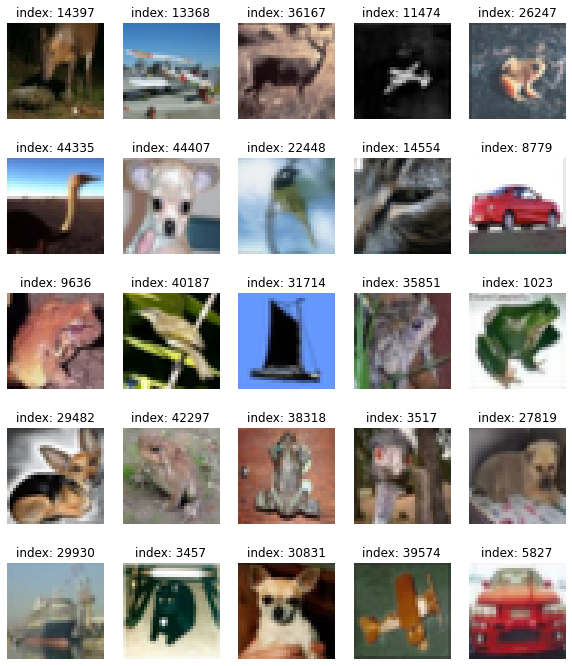

In [ ]:
# 랜덤으로 이미지 25개를 5x5배열로
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_img[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

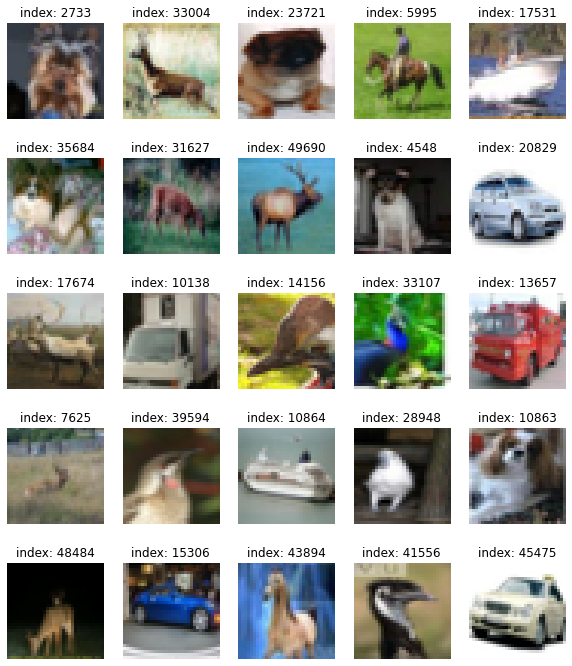

In [ ]:
import random

plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    np.random.seed(i)  # seed 로 고정된 랜덤 사용
    random_i = np.random.randint(1, len(train_x))
    plt.imshow((train_x[random_i]+1)/2)
    plt.title(f'index: {random_i}')
    plt.axis('off')

plt.show()

In [ ]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 256  # 미니 배치 학습

In [ ]:
# numpy ndarray(train_x): 자료를 섞고 배치 사이즈에 따라 나눔
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

In [ ]:
# 생성자 생성 함수
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_6 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_7 (Batc  (None, 8, 8, 128)       

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

#### 2. random noise vector 로 랜덤 이미지 생성

- tf.random.normal([1, 100]): shape=(1,100)이고 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape  # TensorShape([1, 32, 32, 3]) # [batch_size(1), image(32,32,1)]

TensorShape([1, 32, 32, 3])

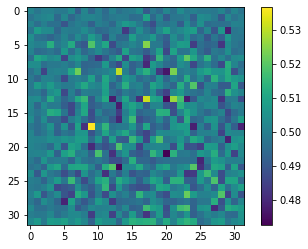

In [ ]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)             

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00058367]], dtype=float32)>

<br>

### STEP 5. 손실함수와 최적화 함수 구현하기

In [ ]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False) 
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절

    save_file_path = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장
    save_file_path = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/training_history/train_history_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'train_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

<br>

### STEP 7. 학습 과정 진행하기

In [ ]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [ ]:
save_every = 5  # 모델 저장 간격
EPOCHS = 50  # 학습 횟수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 2. 모델 학습 진행

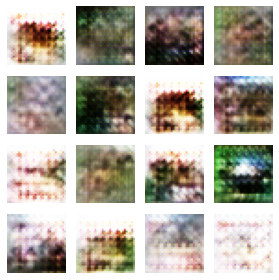

Time for training : 636 sec


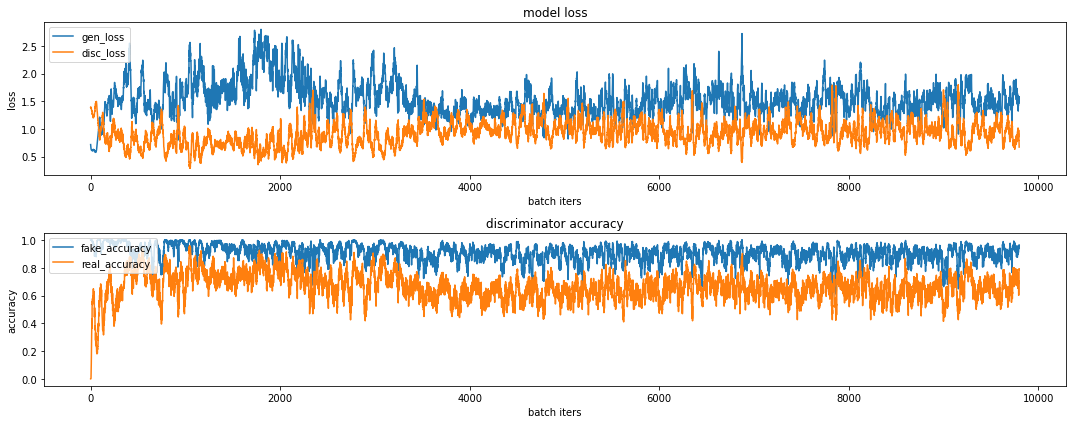

CPU times: user 9min 24s, sys: 1min 15s, total: 10min 39s
Wall time: 10min 37s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every, 1)

In [ ]:
def make_a_gif(anim_file_num=1, flag=True):
    if flag:
        anim_file = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/gif/cifar10_dcgan_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/content/drive/MyDrive/aiffel/ex_14/cifar_10/generated_samples/sample_{}/sample*.png'.format(anim_file_num))  # Fake Images
    else:
        anim_file = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/gif/cifar10_dcgan_history_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/content/drive/MyDrive/aiffel/ex_14/cifar_10/training_history/train_history_{}/train_history*.png'.format(anim_file_num))  # Graphs

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
# Fake Images to GIF
make_a_gif(1, True)

In [ ]:
# History Graphs to GIF
make_a_gif(1, False)

In [ ]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  # subplot 간격 자동 조절
    plt.show()  

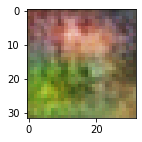

In [ ]:
draw_training_checkpoints_image(1)

<br>

## ✔️STEP 8. (optional) GAN 훈련 과정 개선하기
---


<br>

### - 다른 방안(1)

- 문제 : 이미지를 생성할때 선멍한 이미지를 만들어내지 않는다(뭉뚱그려져서 제대로 label을 잡기 힘들다)

> 해결 : epoch를 증가시키거나/ 하이퍼 파라미터를 변경하는 건 어떨까

> epoch을 늘리고 & 체크포인트를 복구한뒤에 별도의 트레이닝 없이 이미지를 생성하기

In [ ]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

In [ ]:
# 체크 포인트 복구
checkpoint_dir = '/content/drive/MyDrive/aiffel/ex_14/cifar_10/training_checkpints/training_checkpoints_1'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generator = checkpoint.generator
discriminator = checkpoint.discriminator

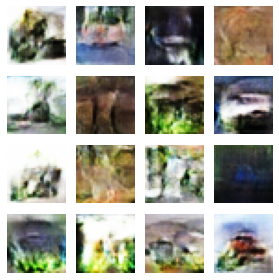

Time for training : 7034 sec


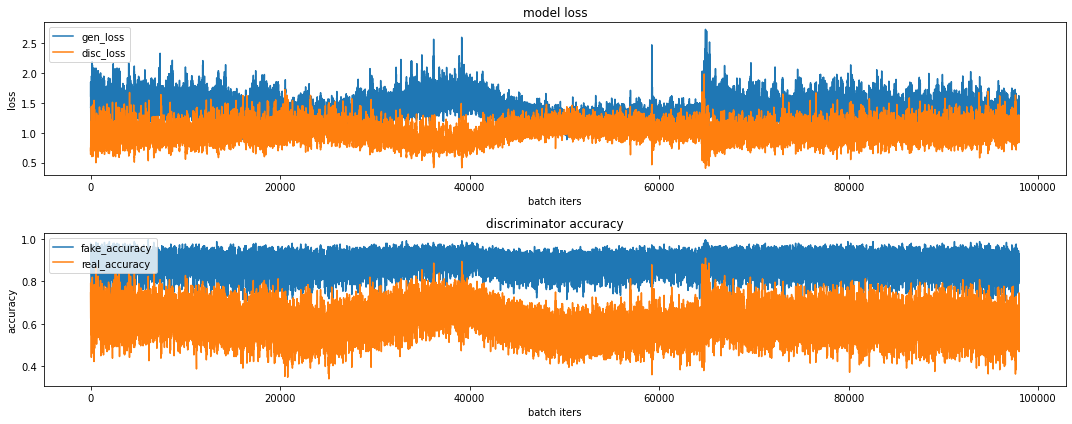

CPU times: user 1h 47min 34s, sys: 12min 20s, total: 1h 59min 54s
Wall time: 1h 57min 20s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every, 2)

In [ ]:
# Fake Images to GIF
make_a_gif(2, True)

# History Graphs to GIF
make_a_gif(2, False)

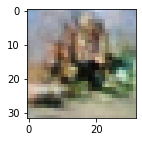

In [ ]:
draw_training_checkpoints_image(2)

<br>

### - 다른 방안(2)

- 문제 : 이미지를 생성할때 선멍한 이미지를 만들어내지 않는다(뭉뚱그려져서 제대로 label을 잡기 힘들다)

> 해결 : 배치사이즈 변경(128), 에폭 사이즈를 500으로, 옵티마이저를 AMSgrad로 변경

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

In [ ]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 128  # 미니 배치 학습

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# 생성자 생성 함수
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 512)        2097152   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)       

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [ ]:
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

In [ ]:
decision = discriminator(generated_image, training=False)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(images):  
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #tf.GradientTape()
        generated_images = generator(noise, training=True)  #generated_images

        #discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #accuracy
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  

In [ ]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

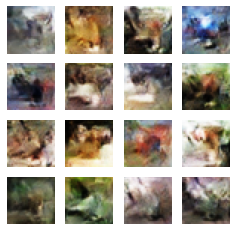

Time for training : 2715 sec


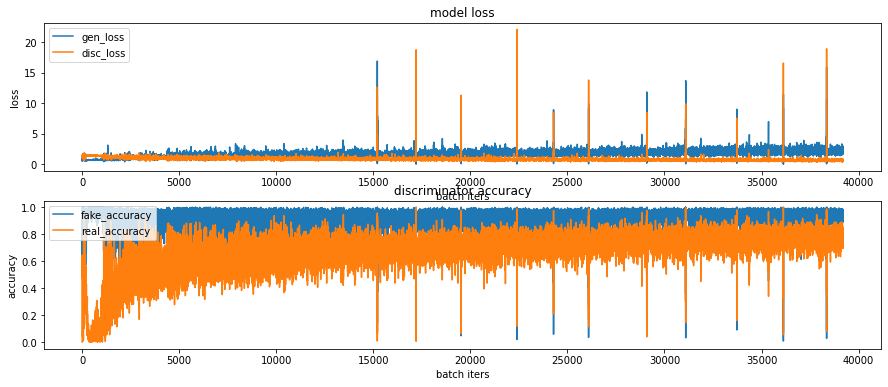

CPU times: user 47min 9s, sys: 4min 19s, total: 51min 28s
Wall time: 45min 17s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

<br>

### ✔️회고 및 결론
---

#### ▶️ 이번 프로젝트에서 어려웠던 점

에폭마다 오래걸리는 시간이 너무 힘들었다. 여러가지 하이퍼 파라미터를 바꾸면서 다양하게 실험해보고 싶었는데, 앞서 13번까지는 아니더라도 14번도 만만찮게 여러 테스트를 하기에는 시간이 제법 걸렸다.

<br>

#### ▶️ 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

![다운로드](https://user-images.githubusercontent.com/100528803/174943206-7ed44a67-e0b2-46df-af44-97931926fa77.gif)

개선점은 2가지였다.
1. 에폭 증가, 체크포인트 살려서 다시 이미지를 생성
2. 배치사이즈 변경, 옵티마이저 변경(AMSgrad)

처음에는 이미지 자체가 형체가 애매해서 라벨을 제대로 붙이는게 쉽지 않았다. 하지만 그만큼 학습시간이 덜 걸렸기 때문에 걸리는 자체는 별로 부담스러운 시간은 아니었다. 하지만 에폭을 대폭 늘린 뒤에는 점차 선명한 이미지가 나오는 동시에 학습 시간이 2시간가까이 걸려서 돌리는데 부담 되었다.
그 다음에는 새로 하이퍼 파라미터를 바꾼뒤에 dence layer를 더 쌓아올렸는데 이 경우는 엄청난 시간이 걸려서 도저히 두번 할 자신 이 없었다. 그래도 처음과는 조금 선명해진 비주얼로 나온 것 같아서 다행이다.

<br>


#### ▶️ 루브릭 평가 지표를 맞추기 위해 시도한 것들

이번 프로젝트에서 루브릭의 기준은 아래와 같았다.

|       |                                    **< 평가문항 >**                                   |                                                              **< 상세기준 >**                                                             |
|-------|:---------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------|
| **1** | GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.                                 | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.<br>                                                        |
| **2** | 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. | gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.                               |
| **3** | 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.                                    | 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다. |

![다운로드 (2)](https://user-images.githubusercontent.com/100528803/174945914-6293e646-08a7-4645-bbee-bcc3944ca65c.png)


만들어진 이미지들은 이제 어느정도 구분이 가능할 정도로 바뀌었고, 동시에 fake accuracy가 0.5까지는 아니더라도 많이 하향되는 구간은 가끔 가다가 나오는 것을 확인할 수 있었다. 하지만 fake accuray와 real_accuracy가 비례적으로 서로 교차되는 건 아니라는 걸 새롭게 알 수 잇엇다. 아마 에폭이 500 정도가 아니라 1500 내지는 2000가량 된다면 시간이 어마어마하게 오래 걸려도 어느정도 하향이 가능하지 않을가 생각하게 만들었다.

<br>

#### ▶️ 자기 다짐

후반부 익스들은 대체적으로 시간과의 싸움이었다. 모델들이 점차 덩치가 커지는 것도 있지만 그만큼 데이터의 크기에 따라서 시간이 점차 오래걸림으로서 미뤄뒀다가 했다가는 원하는 데이터를 제대로 뽑아내기 힘들 수 있다는 생각이 들었다. 이 상태로는 고잉디퍼에서는 더 하겠지 싶어서 시간 배율을 고민하게 만들었다.

<br>

## ✔️Reference(참고자료)
---
* https://openai.com/blog/generative-models/
* https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
* https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/
* https://github.com/soumith/ganhacks
* https://www.tensorflow.org/tutorials/generative/dcgan?hl=ko
* https://eehoeskrap.tistory.com/430
* https://schoolofweb.net/blog/posts/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%8D%B0%EC%BD%94%EB%A0%88%EC%9D%B4%ED%84%B0-decorator/